In [1]:
import numpy as np
import xarray as xr
#import cftime
import warnings
import time
import os
import matplotlib.pyplot as plt
import scipy.stats

import sys
sys.path.append('/glade/u/home/jjeffree/ensemble-analogue-predictability/')
import predictability_tools as pt


In [12]:
client.close()

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0)
client.amm.start()
client

/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42067 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/more_testing/proxy/42067/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/more_testing/proxy/42067/status,Workers: 16
Total threads: 16,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34671,Workers: 16
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/more_testing/proxy/42067/status,Total threads: 16
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42581,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/more_testing/proxy/42933/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35047,


In [3]:
composite_5 = xr.load_dataarray('/glade/work/jjeffree/model_data/composite_5.nc')

In [4]:
models = ['CESM2-LE','ACCESS-ESM1-5','MPI-GE','MIROC6','CanESM5','IPSL-CM6A-L','MIROC-ES2L','GFDL-ES2M','MPI-CMIP6']
models.sort()

In [5]:
composite_5.origin[9]

<xarray.DataArray 'origin' ()> Size: 108B
array('ACCESS-ESM1-5+anomexcept10P', dtype='<U27')
Coordinates:
    L        int64 8B 12
    origin   <U27 108B 'ACCESS-ESM1-5+anomexcept10P'
    time     datetime64[ns] 8B 2009-01-01

In [6]:
#Don't run this more than once you idiot
run=input('Are you _SURE_ you want to run this cell')
model_nino34 = {}
for i in range(9):
    mod = models[i]
    model_ss = pt.get_025_ss[mod+'_nomean']()
    nino34 = pt.average_region(model_ss.sel(var='tos'),
                                region=pt.nino34_region,
                                lon_coord = 'lon', lat_coord ='lat',
                                lon_dim='lon',lat_dim='lat')
    model_nino34[mod] = nino34

Are you _SURE_ you want to run this cell 


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending 

In [7]:
forecast_nino34 = {}

for i in range(9):
    mod = models[i]

    analogues = xr.open_mfdataset('/glade/work/jjeffree/results/area/base/detail'+
                              '/composite_5_'+mod+'_nomean_tos_zos/*.nc',decode_cf=False)
    analogues = xr.decode_cf(analogues)
    for origin in (0,9,18,27,36):
    
        forecast_nino34[(origin,mod)] = model_nino34[mod].shift(time=-12).sel(SMILE_M=analogues.analogue_SMILE_M.isel(Y=origin+i),
                                   time=analogues.analogue_init_time.isel(Y=origin+i))


In [8]:
light_blue = '#7CABCD'
grey = '#858484'
light_red = '#E0997C'

In [ ]:
colors = '#973695','#D7A0D5'

def scatter_nino_changes(m0,m1,m2,i0,i1,i2,legend=False):
    mm = []
    space = 0.25
    for i in range(9):
        mod = models[i]
        leg0 = plt.scatter([i-space]*forecast_nino34[(i0,mod)].lib_mi.shape[0],forecast_nino34[(i0,mod)].sel(mask=m0).mean('M'),c=light_blue,marker='^',)
        leg1 = plt.scatter([i]*forecast_nino34[(i1,mod)].lib_mi.shape[0],forecast_nino34[(i1,mod)].sel(mask=m1).mean('M'),c=grey,marker='o',)
        leg2 = plt.scatter([i+space]*forecast_nino34[(i2,mod)].lib_mi.shape[0],forecast_nino34[(i2,mod)].sel(mask=m2).mean('M'),c=light_red,marker='s',)
    
        plt.plot((i-space,i,i+space), (forecast_nino34[(i0,mod)].sel(mask=m0).mean(('M','lib_mi')),
                                   forecast_nino34[(i1,mod)].sel(mask=m1).mean(('M','lib_mi')),
                                   forecast_nino34[(i2,mod)].sel(mask=m2).mean(('M','lib_mi'))),
                 c='k',
                 linewidth=2,
                )
        mm.append(xr.concat((forecast_nino34[(i0,mod)].sel(mask=m0).mean(('M','lib_mi')),
                                   forecast_nino34[(i1,mod)].sel(mask=m1).mean(('M','lib_mi')),
                                   forecast_nino34[(i2,mod)].sel(mask=m2).mean(('M','lib_mi'))),'anomchange'))
    mm = xr.concat(mm,'model').mean('model') 
    plt.plot((i+1-space,i+1,i+1+space), mm,
             c='k',
             linewidth=2,
             
            )
    for j in range(3):
        plt.scatter((i+1-space,i+1,i+1+space)[j], mm[j],
                 c=(light_blue,grey,light_red)[j],
                 marker='^os'[j],
                zorder=-1,
                )
    plt.axvspan(i+0.5,i+2,facecolor='grey',edgecolor='None',alpha=0.2)
    
    plt.xticks(np.arange(10)+0.15,models+['multimodel mean'],rotation=90)
    plt.xlim(-0.5,i+1.6)
    if legend:
        plt.legend((leg0,leg1,leg2), ('opposing anomaly','no anomaly', 'additive anomaly'))
    

fig, axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(15,10))
plt.sca(axs[0,0])
scatter_nino_changes('10P_12m2varagreement30A','10P_12m2varagreement30A','10P_12m2varagreement30A',18,0,9) 
plt.title('a) Tropical Atlantic Ocean',loc='left')
plt.ylabel('NINO34')

plt.sca(axs[0,1])
scatter_nino_changes('10P_12m2varagreement30I','10P_12m2varagreement30I','10P_12m2varagreement30I',18,0,9,legend=True) 
plt.title('b) Tropical Indian Ocean',loc='left')


plt.sca(axs[1,0])
scatter_nino_changes('10P_12m2varagreement10-30P','10P_12m2varagreement10-30P','10P_12m2varagreement10-30P',18,0,9) 
plt.title('c) North tropical Pacific Ocean',loc='left')
plt.ylabel('NINO34')


plt.sca(axs[1,1])
scatter_nino_changes('10P_12m2varagreement30-10P','10P_12m2varagreement30-10P','10P_12m2varagreement30-10P',18,0,9) 
plt.title('d) South tropical Pacific Ocean',loc='left')

plt.subplots_adjust(wspace=0.1,hspace=0.15)
plt.savefig('figures/area_forced_anomalies.pdf',bbox_inches='tight')

Text(0.0, 1.0, 'd) South Ocean')

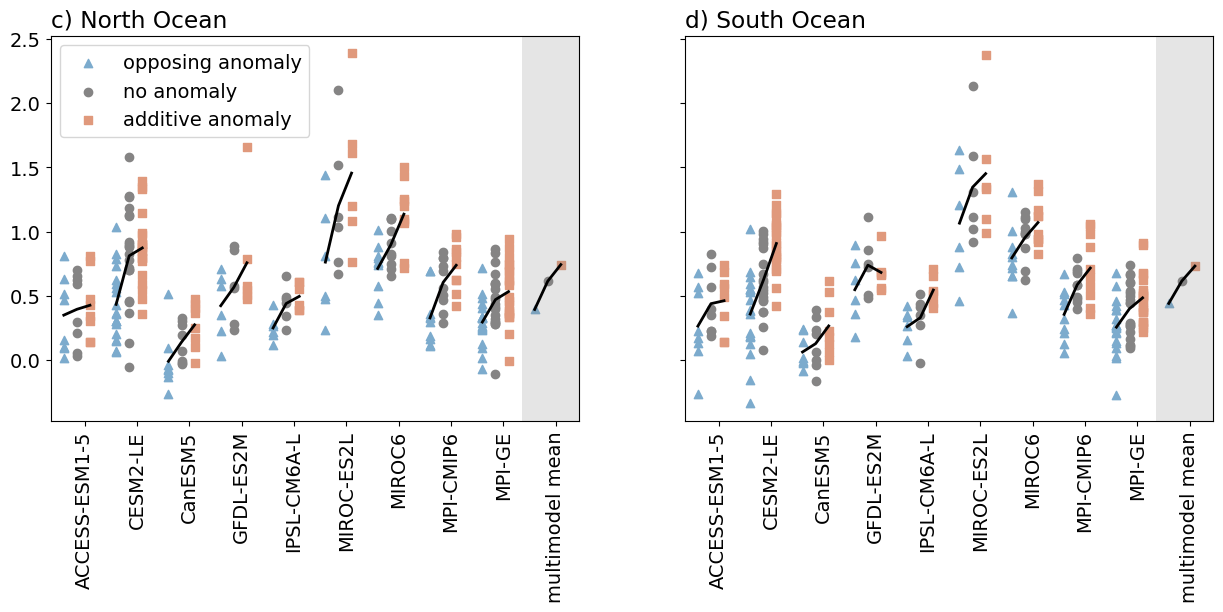

In [15]:
fig, axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,5))

plt.sca(axs[0])
scatter_nino_changes('10P_12m2varagreement30N','10P_12m2varagreement30N','10P_12m2varagreement30N',18,0,9,legend=True) 
plt.title('c) North Ocean',loc='left')


plt.sca(axs[1])
scatter_nino_changes('10P_12m2varagreement30S','10P_12m2varagreement30S','10P_12m2varagreement30S',18,0,9) 
plt.title('d) South Ocean',loc='left')

In [18]:
mm_10P_init = []
mm_10P30A_init = []
mm_10P_12m = []
mm_10P30A_12m = []

mask = '10P_12m2varagreement30A'
i0 = 0
i1 = 9

for i in range(9):
    mod = models[i]

    model_ss = pt.get_025_ss[mod+'_nomean']().sel(var='tos').load()
    
    analogues1 = xr.open_mfdataset('/glade/work/jjeffree/results/area/base/detail'+
                                  '/composite_5_'+mod+'_nomean_tos_zos/*.nc',decode_cf=False).sel(mask=mask)
    analogues1 = xr.decode_cf(analogues1)

    mm_10P_init.append(model_ss.sel(SMILE_M=analogues1.analogue_SMILE_M,
                               time=analogues1.analogue_init_time).isel(Y=i0+i).mean(('lib_mi','M')))
    mm_10P30A_init.append(model_ss.sel(SMILE_M=analogues1.analogue_SMILE_M,
                               time=analogues1.analogue_init_time).isel(Y=i1+i).mean(('lib_mi','M')))

    mm_10P_12m.append(model_ss.shift(time=-12).sel(SMILE_M=analogues1.analogue_SMILE_M,
                               time=analogues1.analogue_init_time).isel(Y=i0+i).mean(('lib_mi','M')))
    mm_10P30A_12m.append(model_ss.shift(time=-12).sel(SMILE_M=analogues1.analogue_SMILE_M,
                               time=analogues1.analogue_init_time).isel(Y=i1+i).mean(('lib_mi','M')))
    
    print(mod)

/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


ACCESS-ESM1-5


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.93 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CESM2-LE


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CanESM5


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


GFDL-ES2M


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.15 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


IPSL-CM6A-L


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MIROC-ES2L


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MIROC6


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 191.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MPI-CMIP6


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 193.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MPI-GE


In [20]:
merged_dataset = xr.Dataset({'10P_init':xr.concat(mm_10P_init,'model'),
                             '10P30A_init':xr.concat(mm_10P30A_init,'model'),
                             '10P_12m':xr.concat(mm_10P_12m,'model'),
                             '10P30A_12m':xr.concat(mm_10P30A_12m,'model')}).isel(pred_SMILE_M=0)
merged_dataset.to_netcdf('/glade/derecho/scratch/jjeffree/250207_area_adding_atlantic_init_changes.nc')

In [10]:
# full_dataset_init = {}
# full_dataset_12m = {}

# for mask in ('10P','10P_12m2varagreement30A','10P_12m2varagreement30I','10P_12m2varagreement10-30P','10P_12m2varagreement30-10P','10P_12m2varagreement30N','10P_12m2varagreement30S'):
#     full_dataset_init[mask]=[]
#     full_dataset_12m[mask]=[]

# i1 = 9

for i in range(2,9):
    mod = models[i]
    model_ss = pt.get_025_ss[mod+'_nomean']().sel(var='tos').load()

    for mask in ('10P_12m2varagreement30A','10P_12m2varagreement30I','10P_12m2varagreement10-30P','10P_12m2varagreement30-10P','10P_12m2varagreement30N','10P_12m2varagreement30S'):
    
        analogues1 = xr.open_mfdataset('/glade/work/jjeffree/results/area/base/detail'+
                                      '/composite_5_'+mod+'_nomean_tos_zos/*.nc',decode_cf=False).sel(mask=mask)
        analogues1 = xr.decode_cf(analogues1)
    
        full_dataset_init[mask].append(model_ss.sel(SMILE_M=analogues1.analogue_SMILE_M,
                                   time=analogues1.analogue_init_time).isel(Y=i1+i).mean(('lib_mi','M')))
    
        full_dataset_12m[mask].append(model_ss.shift(time=-12).sel(SMILE_M=analogues1.analogue_SMILE_M,
                                   time=analogues1.analogue_init_time).isel(Y=i1+i).mean(('lib_mi','M')))
        
    full_dataset_init['10P'].append(model_ss.sel(SMILE_M=analogues1.analogue_SMILE_M,
                                   time=analogues1.analogue_init_time).isel(Y=i).mean(('lib_mi','M'))).assign_coords({'mask':np.array(('10P',))})
    
    full_dataset_12m['10P'].append(model_ss.shift(time=-12).sel(SMILE_M=analogues1.analogue_SMILE_M,
                                   time=analogues1.analogue_init_time).isel(Y=i).mean(('lib_mi','M'))).assign_coords({'mask':np.array(('10P',))})
        
    print(mod)

/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CanESM5


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


GFDL-ES2M


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.15 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


IPSL-CM6A-L


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MIROC-ES2L


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 192.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MIROC6


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 191.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MPI-CMIP6


/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 193.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


MPI-GE


In [44]:
xr_full_dataset_init={}
xr_full_dataset_12m={}
for k in full_dataset_init.keys():
    xr_full_dataset_init[k]=xr.concat(full_dataset_init[k],'model')
    xr_full_dataset_12m[k]=xr.concat(full_dataset_12m[k],'model')
    if k =='10P':
            xr_full_dataset_init[k]=xr.concat(full_dataset_init[k],'model').assign_coords({'mask':np.array(('10P'))})
            xr_full_dataset_12m[k]=xr.concat(full_dataset_12m[k],'model').assign_coords({'mask':np.array(('10P'))})    

In [45]:
xr.concat([xr_full_dataset_init[k] for k in xr_full_dataset_init.keys()],'mask').isel(pred_SMILE_M=0).to_netcdf('/glade/derecho/scratch/jjeffree/250207_full_dataset_init.nc')
xr.concat([xr_full_dataset_12m[k] for k in xr_full_dataset_init.keys()],'mask').isel(pred_SMILE_M=0).to_netcdf('/glade/derecho/scratch/jjeffree/250207_full_dataset_12m.nc')

In [46]:
merged_init = xr.concat([xr_full_dataset_init[k] for k in xr_full_dataset_init.keys()],'mask').isel(pred_SMILE_M=0)

In [47]:
merged_12m = xr.concat([xr_full_dataset_12m[k] for k in xr_full_dataset_init.keys()],'mask').isel(pred_SMILE_M=0)

In [6]:
merged_init = xr.load_dataarray('/glade/derecho/scratch/jjeffree/250207_full_dataset_init.nc')
merged_12m = xr.load_dataarray('/glade/derecho/scratch/jjeffree/250207_full_dataset_12m.nc')

In [7]:
merged_init = merged_init.roll({'lon':-10},roll_coords=True)
merged_init = merged_init.assign_coords({'lon':(merged_init.lon-25)%360+25})
merged_12m = merged_12m.roll({'lon':-10},roll_coords=True)
merged_12m = merged_12m.assign_coords({'lon':(merged_init.lon-25)%360+25})

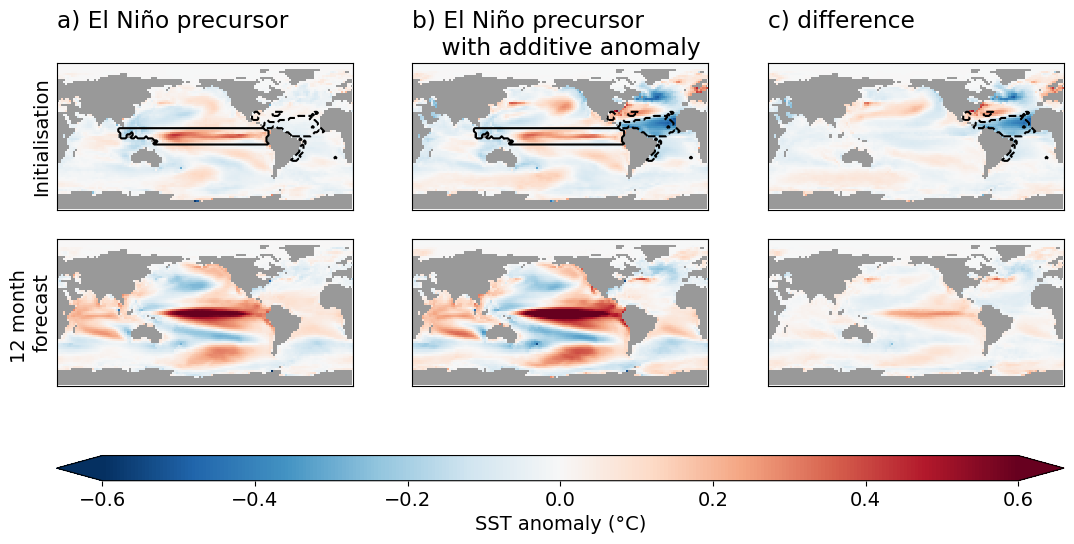

In [11]:
fig, axs = plt.subplots(2,3,figsize=(13,6))

for i in range(3):
    for j in range(2):
        plt.sca(axs[j,i])
        plt.contourf(merged_init.lon,merged_init.lat,~np.isnan(pt.mask_dict['G'].roll({'lon':-10})),levels=(0.1,1.5),colors='#999999',zorder=-100)

plt.sca(axs[0,0])
cmap1 = plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,pt.mask_dict['10P'].roll({'lon':-10}),levels=(0.5,),colors='k')
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30A'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('Initialisation')
plt.title('a) El Niño precursor\n',loc='left')

plt.sca(axs[0,1])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P_12m2varagreement30A').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,pt.mask_dict['10P'].roll({'lon':-10},roll_coords=True),levels=(0.5,),colors='k')
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30A'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('')
plt.title('b) El Niño precursor \n    with additive anomaly',loc='left')

plt.sca(axs[0,2])
cmap2 = plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P_12m2varagreement30A').mean('model')-merged_init.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30A'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('c) difference\n',loc='left')

plt.sca(axs[1,0])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('12 month \nforecast')

plt.sca(axs[1,1])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P_12m2varagreement30A').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

plt.sca(axs[1,2])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P_12m2varagreement30A').mean('model')-merged_12m.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

fig.colorbar(cmap1,ax=axs[:,:],orientation = 'horizontal',aspect=40,extend='both',label='SST anomaly (°C)')
#fig.colorbar(cmap2,ax=axs[:,2:],orientation = 'horizontal',extend='both',label='SST anomaly (°C)')
plt.savefig('figures/area_forced_anomalies_map.pdf',bbox_inches='tight')

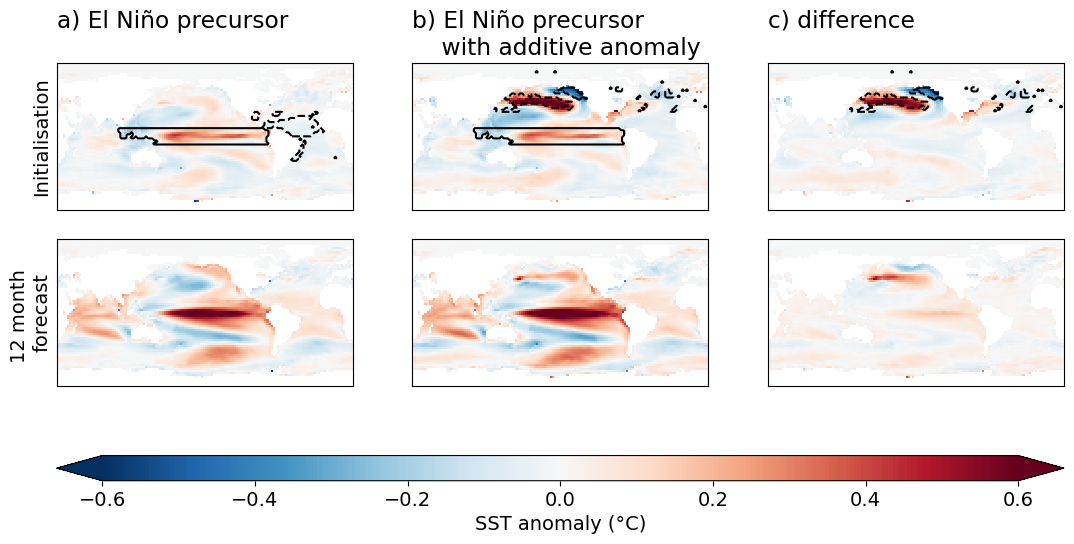

In [47]:
fig, axs = plt.subplots(2,3,figsize=(13,6))

plt.sca(axs[0,0])
cmap1 = plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,pt.mask_dict['10P'].roll({'lon':-10}),levels=(0.5,),colors='k')
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30A'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('Initialisation')
plt.title('a) El Niño precursor\n',loc='left')

plt.sca(axs[0,1])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P_12m2varagreement30N').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,pt.mask_dict['10P'].roll({'lon':-10},roll_coords=True),levels=(0.5,),colors='k')
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30N'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('')
plt.title('b) El Niño precursor \n    with additive anomaly',loc='left')

plt.sca(axs[0,2])
cmap2 = plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P_12m2varagreement30N').mean('model')-merged_init.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30N'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('c) difference\n',loc='left')

plt.sca(axs[1,0])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('12 month \nforecast')

plt.sca(axs[1,1])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P_12m2varagreement30N').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

plt.sca(axs[1,2])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P_12m2varagreement30N').mean('model')-merged_12m.sel(mask='10P').mean('model'),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

fig.colorbar(cmap1,ax=axs[:,:],orientation = 'horizontal',aspect=40,extend='both',label='SST anomaly (°C)')

In [49]:
merged_init

<xarray.DataArray (mask: 7, model: 9, lat: 72, lon: 144)> Size: 5MB
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-2.20137756e-03, -2.09398801e-03, -2.01241628e-03, ...,
          -2.42039432e-03, -2.36554138e-03, -2.31774911e-03],
         [-1.34260311e-03, -1.50603797e-03, -1.62292091e-03, ...,
          -1.26803870e-03, -1.28771269e-03, -1.29580343e-03],
         [ 7.06643882e-04,  7.10978210e-04,  7.35944598e-04, ...,
           6.97435612e-04,  6.88808518e-04,  6.82999795e-04]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
         [ 1.88307762e-05,  1.44100984e-05,  2.70283222e-05, ...,
           1.33435885e-05,  2.15155125e-05,  2.43583043e-05],
         [-1.49337451e-06, -3.10530663e-06, -2.96928088e-06, ...,
          -4.01213964e-06, -5.21130562e-06, -4.06926473e-06],
         [ 1.57646338e-05,  1.63769404e-05,  1.69045607e-05, ...,
           1.21388117e-05,  1.30137444e-05,  1.50421460e-05]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [ 2.89775533e-05,  2.31555175e-05,  1.18209876e-05, ...,
           2.67888285e-05,  3.09078546e-05,  3.35419607e-05],
         [ 4.07947642e-06,  3.96284470e-06,  4.74985656e-06, ...,
          -2.20954522e-07,  1.62434439e-06,  2.12238511e-06],
         [ 5.08537848e-06,  4.42241032e-06,  3.85265087e-06, ...,
           9.15167250e-06,  8.56758989e-06,  5.83319383e-06]]]])
Coordinates:
  * lat           (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
    var           <U3 12B 'tos'
  * mask          (mask) <U26 728B '10P' ... '10P_12m2varagreement30S'
    pred_SMILE_M  int64 8B 1
  * lon           (lon) float64 1kB 26.25 28.75 31.25 ... 378.8 381.2 383.8
Dimensions without coordinates: model

Text(0.5, 0.98, 'MIROC-ES2L being indifferent to the south tropical Pacific\n\n\n.')

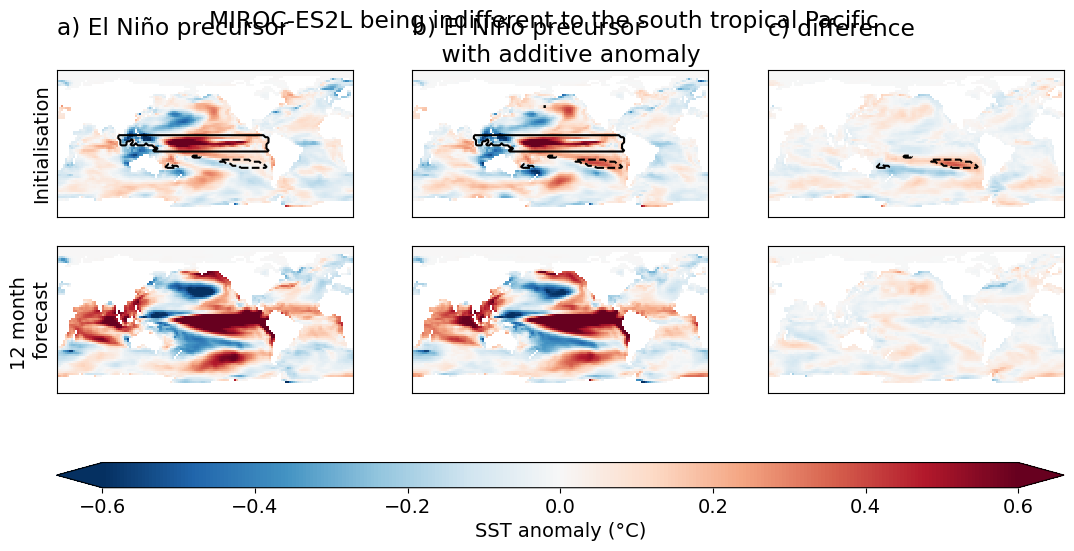

In [57]:
fig, axs = plt.subplots(2,3,figsize=(13,6))

plt.sca(axs[0,0])
cmap1 = plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P').isel(model=5),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,pt.mask_dict['10P'].roll({'lon':-10}),levels=(0.5,),colors='k')
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30-10P'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('Initialisation')
plt.title('a) El Niño precursor\n',loc='left')

plt.sca(axs[0,1])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P_12m2varagreement30-10P').isel(model=5),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,pt.mask_dict['10P'].roll({'lon':-10},roll_coords=True),levels=(0.5,),colors='k')
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30-10P'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('')
plt.title('b) El Niño precursor \n    with additive anomaly',loc='left')

plt.sca(axs[0,2])
cmap2 = plt.pcolormesh(merged_init.lon,merged_init.lat,merged_init.sel(mask='10P_12m2varagreement30-10P').isel(model=5)-merged_init.sel(mask='10P').isel(model=5),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.contour(merged_init.lon,merged_init.lat,
            (pt.mask_dict['10P_12m2varagreement30-10P'].sel(var='tos')-pt.mask_dict['10P']).roll({'lon':-10},roll_coords=True),
            levels=(0.5,),colors='k',linestyles=('dashed',))
plt.xticks([])
plt.yticks([])
plt.title('c) difference\n',loc='left')

plt.sca(axs[1,0])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P').isel(model=5),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('12 month \nforecast')

plt.sca(axs[1,1])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P_12m2varagreement30-10P').isel(model=5),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

plt.sca(axs[1,2])
plt.pcolormesh(merged_init.lon,merged_init.lat,merged_12m.sel(mask='10P_12m2varagreement30-10P').isel(model=5)-merged_12m.sel(mask='10P').isel(model=5),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

fig.colorbar(cmap1,ax=axs[:,:],orientation = 'horizontal',aspect=40,extend='both',label='SST anomaly (°C)')
plt.suptitle('MIROC-ES2L being indifferent to the south tropical Pacific\n\n\n')

Text(0.5, 0.98, 'ACCESS-ESM1-5')

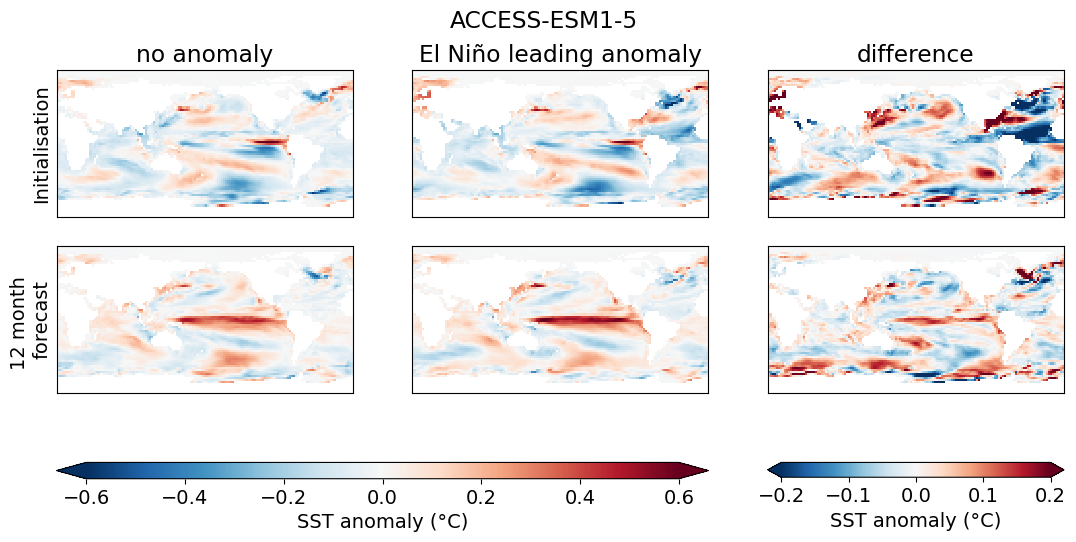

In [30]:
fig, axs = plt.subplots(2,3,figsize=(13,6))

plt.sca(axs[0,0])
cmap1 = plt.pcolormesh(merged_dataset.lon,merged_dataset.lat,merged_dataset['10P_init'].isel(model=0),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
#plt.gca().axis('off')
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('Initialisation')
plt.title('no anomaly')

plt.sca(axs[0,1])
plt.pcolormesh(merged_dataset.lon,merged_dataset.lat,merged_dataset['10P30A_init'].isel(model=0),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')
plt.title('El Niño leading anomaly')

plt.sca(axs[0,2])
cmap2 = plt.pcolormesh(merged_dataset.lon,merged_dataset.lat,merged_dataset['10P30A_init'].isel(model=0)-merged_dataset['10P_init'].isel(model=0),vmin=-0.2,vmax=0.2,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('difference')

plt.sca(axs[1,0])
plt.pcolormesh(merged_dataset.lon,merged_dataset.lat,merged_dataset['10P_12m'].isel(model=0),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')
plt.ylabel('12 month \nforecast')

plt.sca(axs[1,1])
plt.pcolormesh(merged_dataset.lon,merged_dataset.lat,merged_dataset['10P30A_12m'].isel(model=0),vmin=-0.6,vmax=0.6,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

plt.sca(axs[1,2])
plt.pcolormesh(merged_dataset.lon,merged_dataset.lat,merged_dataset['10P30A_12m'].isel(model=0)-merged_dataset['10P_12m'].isel(model=0),vmin=-0.2,vmax=0.2,cmap='RdBu_r',rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')

fig.colorbar(cmap1,ax=axs[:,:2],orientation = 'horizontal',aspect=40,extend='both',label='SST anomaly (°C)')
fig.colorbar(cmap2,ax=axs[:,2:],orientation = 'horizontal',extend='both',label='SST anomaly (°C)')
plt.suptitle('ACCESS-ESM1-5')